#  Phase 1.2 – Return & Volatility Diagnostics

## 1. Load Data
- Load `solana_cleaned_ohlcv.parquet`
- Print shape, unique tokens, date range

## 2. Compute Returns
- `logret_12h` = log(close / close.shift(1)) by token
- `logret_72h` = log(close.shift(-6) / close) by token

## 3. Distribution Diagnostics
- Histograms + KDE for `logret_12h`, `logret_72h`
- Skewness, kurtosis (overall + by token)

## 4. ACF/PACF Analysis
- ACF & PACF plots for:
  - `logret_12h`
  - `|logret_12h|` (to check volatility clustering)

## 5. Notes & Interpretation
- Discuss fat tails, volatility persistence
- Comment on implications for interval prediction


In [17]:
# Load and Preview

import pandas as pd
import numpy as np

df = pd.read_parquet("C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/solana_cleaned_ohlcv.parquet")

print(df.shape)
print("Tokens:", df['token'].nunique())
print("Date Range:", df['timestamp'].min(), "→", df['timestamp'].max())


(6464, 32)
Tokens: 21
Date Range: 2024-12-05 12:00:00 → 2025-06-03 12:00:00


In [18]:
# Compute Returns
df = df.sort_values(['token', 'timestamp'])

# 12h log return
df['logret_12h'] = df.groupby('token')['close_usd'].transform(lambda x: np.log(x / x.shift(1)))

# 72h log return
df['logret_72h'] = df.groupby('token')['close_usd'].transform(lambda x: np.log(x.shift(-6) / x))

##  Return Distributions:

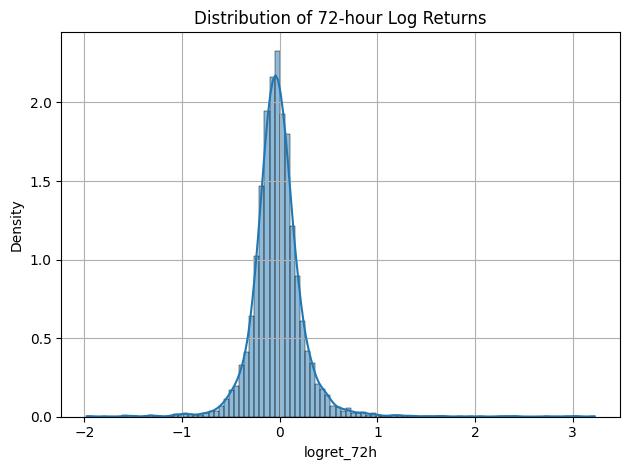

Skewness: 1.6819713484594117
Kurtosis: 20.730728722685107


In [44]:
# Return Distributions:

from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Clean series
returns = (df['logret_72h']
           .replace([np.inf, -np.inf], np.nan)
           .dropna())

# 2) Output folder (relative to project root; adjust if needed)
outdir = Path("/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/paper/figures/raw")
outdir.mkdir(parents=True, exist_ok=True)

# 3) Plot
fig, ax = plt.subplots()
sns.histplot(returns, kde=True, bins=100, stat="density", ax=ax)
ax.set_title("Distribution of 72-hour Log Returns")
ax.set_xlabel("logret_72h")
ax.set_ylabel("Density")
ax.grid(True)
fig.tight_layout()

# 4) Save as vector (best for LaTeX/Quarto)
fig.savefig(outdir / "fig-3-1.pdf",format="pdf", bbox_inches="tight")

# 5) (Optional) show after saving
plt.show()


print("Skewness:", skew(returns))
print("Kurtosis:", kurtosis(returns))






## ACF/PACF

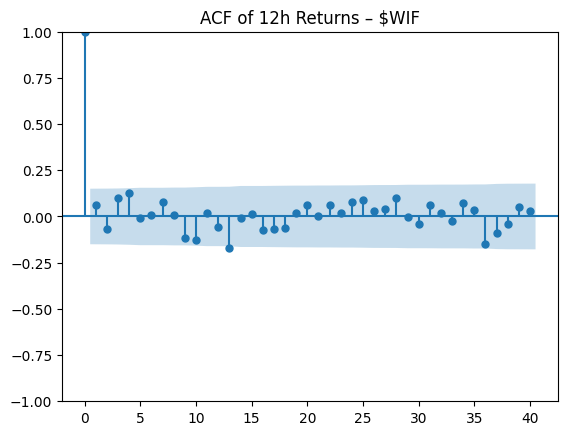

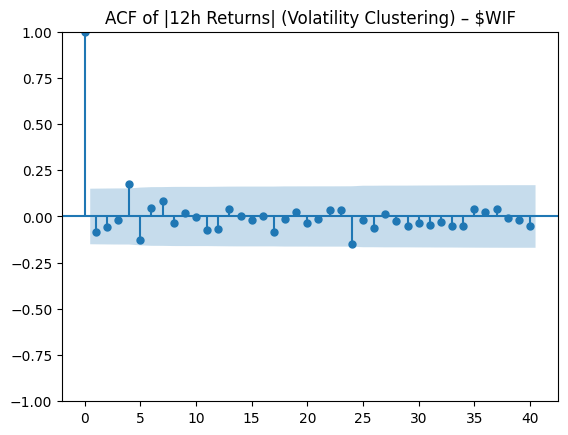

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sample one token for visualization
sample_token = df['token'].unique()[0]
sub = df[df['token'] == sample_token].dropna()

# ACF of returns
plot_acf(sub['logret_12h'], lags=40)
plt.title(f"ACF of 12h Returns – {sample_token}")
plt.show()

# ACF of absolute returns
plot_acf(np.abs(sub['logret_12h']), lags=40)
plt.title(f"ACF of |12h Returns| (Volatility Clustering) – {sample_token}")
plt.show()


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import seaborn as sns

# Compute ACF (|returns|) up to lag 20 for each token
acf_results = []

for token in df['token'].unique():
    sub = df[df['token'] == token].dropna(subset=['logret_12h'])
    if len(sub) < 50:
        continue
    acf_vals = acf(np.abs(sub['logret_12h']), nlags=20, fft=False)
    for lag, val in enumerate(acf_vals):
        acf_results.append({'token': token, 'lag': lag, 'acf_abs': val})

acf_df = pd.DataFrame(acf_results)


c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args

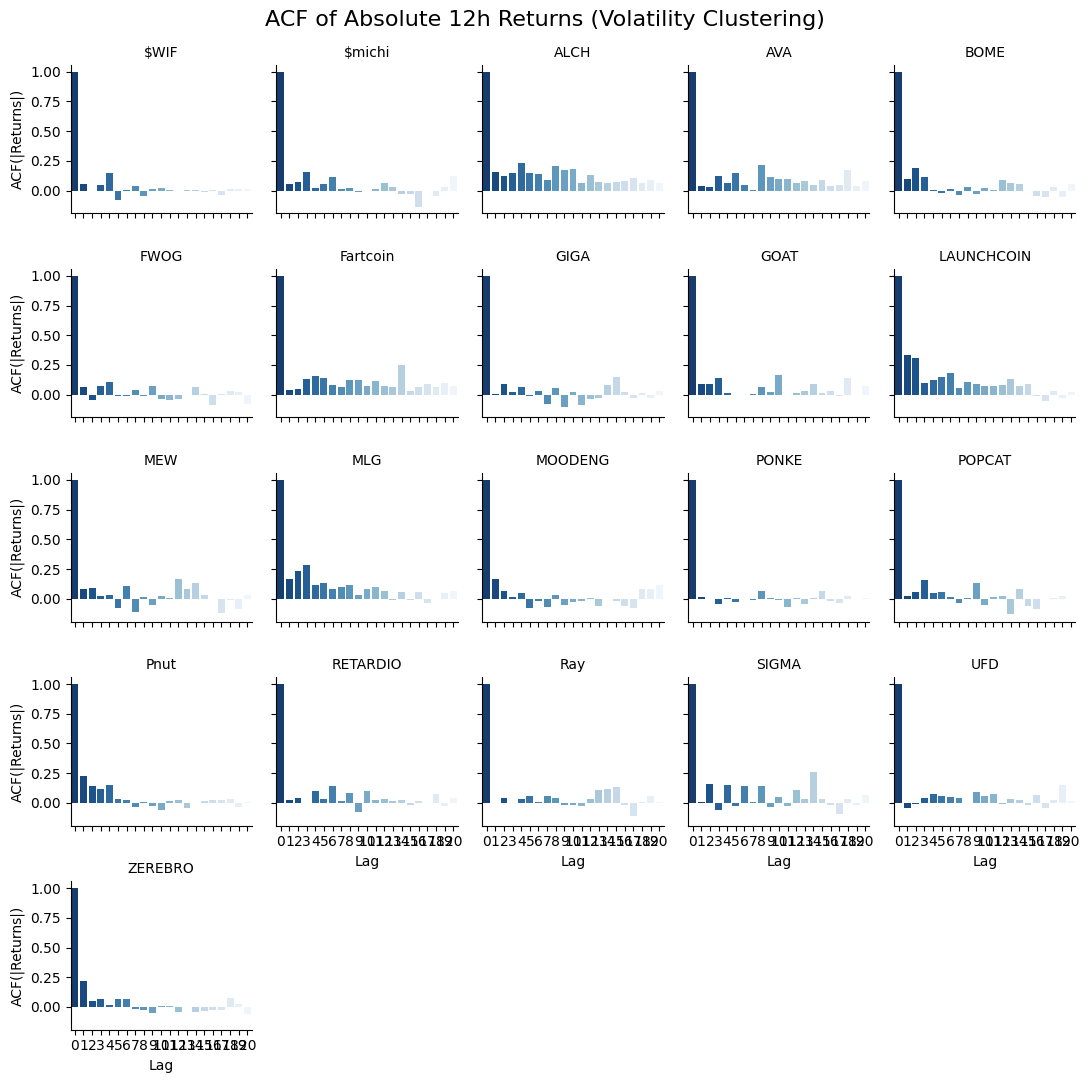

In [22]:
g = sns.FacetGrid(acf_df, col="token", col_wrap=5, height=2.2, sharey=True)
g.map_dataframe(sns.barplot, x="lag", y="acf_abs", palette="Blues_r", order=range(21))
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Lag", "ACF(|Returns|)")
plt.subplots_adjust(top=0.93)
g.fig.suptitle("ACF of Absolute 12h Returns (Volatility Clustering)", fontsize=16)
plt.show()


# Addition Return Analysis EDA:

| Idea                           | Insight                                                       |
| ------------------------------ | ------------------------------------------------------------- |
| 📈 Tail return event frequency | Measures how often large jumps happen                         |
| 🧮 Rolling skewness            | Detects asymmetry shifts over time                            |
| 📉 Return–volatility link      | Tests for leverage effect (risk spikes after drops)           |
| 📊 Regime-wise return shape    | Explores how macro context (SOL) changes token behaviour      |
| 🎯 Forecast error autocorr     | Helps diagnose where models might systematically underperform |


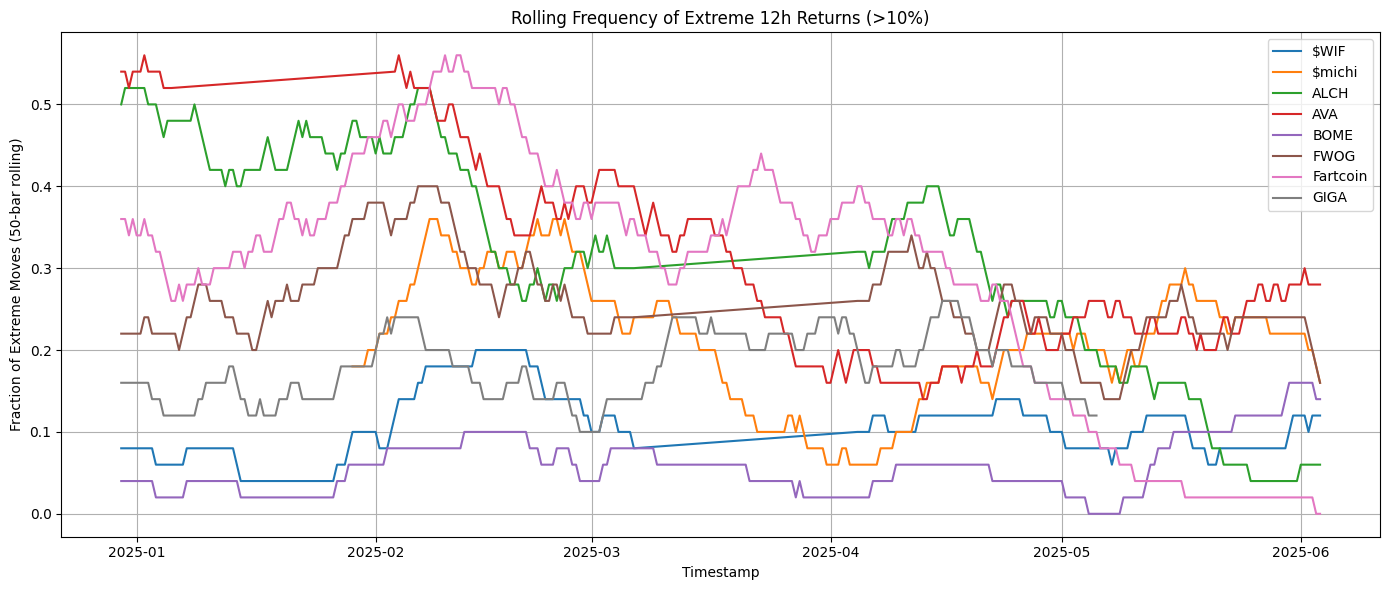

In [23]:
# 1. Tail Return Frequency Over Time
# Define extreme movement (you can tweak 10% threshold)
df['extreme_move'] = np.abs(df['logret_12h']) > 0.10

# Rolling rate of extreme events per token (50 steps = 25 days)
df['extreme_freq'] = df.groupby('token')['extreme_move'].transform(lambda x: x.rolling(50).mean())

# Plot for a few tokens
import matplotlib.pyplot as plt

tokens = df['token'].unique()[:8]  # change to your top tokens

plt.figure(figsize=(14, 6))
for token in tokens:
    sub = df[df['token'] == token]
    plt.plot(sub['timestamp'], sub['extreme_freq'], label=token)
    
plt.title("Rolling Frequency of Extreme 12h Returns (>10%)")
plt.ylabel("Fraction of Extreme Moves (50-bar rolling)")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Extreme Return Frequency

To assess how often large return shocks occur, we defined an "extreme move" as any 12h return greater than ±10%.

## Rolling Frequency of Extreme Returns (>10%)

We computed the fraction of 12h intervals where token returns exceeded ±10%, using a 50-bar rolling window. Key findings:

- Several tokens exhibited **high base rates** of tail events (e.g. AVA, ALCH, Fartcoin), with 30–50% of bars showing extreme moves.
- **Volatility regimes are visible** — some tokens transition from high-spike environments into quieter phases over time.
- This confirms the presence of **return heteroskedasticity** and **nonstationarity** across tokens.

These patterns strongly support the use of:
- **Quantile Regression Forests**, which adapt interval width based on local volatility conditions.
- **Time-sensitive features** such as rolling volatility, max drawdowns, or macro regime indicators.
- **Rolling-window CV**, ensuring models are evaluated across both high- and low-volatility periods.


## Tail Asymmetry Index

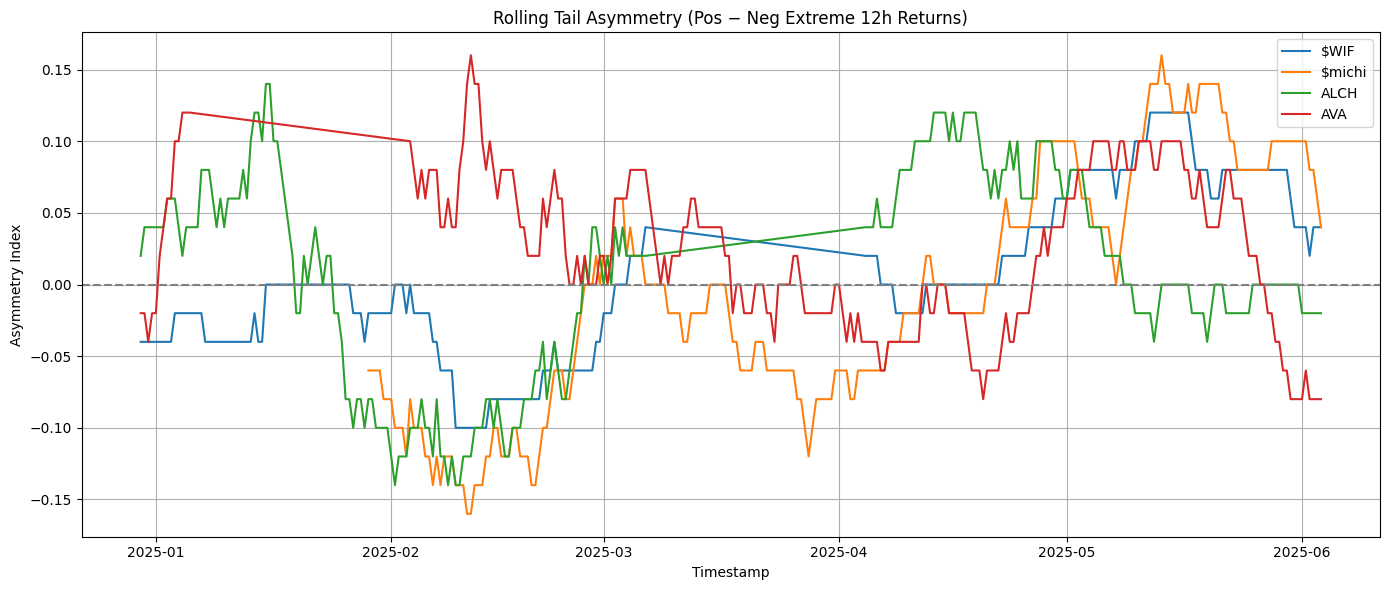

In [24]:
# Flag Large Positive/Negative Moves
# Threshold for extreme moves
THRESH = 0.10  # 10% return

df['tail_pos'] = df['logret_12h'] > THRESH
df['tail_neg'] = df['logret_12h'] < -THRESH

# Rolling Counts (50 bars)

df['tail_pos_rolling'] = df.groupby('token')['tail_pos'].transform(lambda x: x.rolling(50).mean())
df['tail_neg_rolling'] = df.groupby('token')['tail_neg'].transform(lambda x: x.rolling(50).mean())

# Compute Asymmetry Index
df['tail_asymmetry'] = df['tail_pos_rolling'] - df['tail_neg_rolling']

import matplotlib.pyplot as plt

tokens = df['token'].unique()[:4]  # change if needed

plt.figure(figsize=(14, 6))
for token in tokens:
    sub = df[df['token'] == token]
    plt.plot(sub['timestamp'], sub['tail_asymmetry'], label=token)

plt.axhline(0, color='grey', linestyle='--')
plt.title("Rolling Tail Asymmetry (Pos − Neg Extreme 12h Returns)")
plt.ylabel("Asymmetry Index")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Tail Asymmetry Dynamics

We computed a rolling "tail asymmetry index" as the difference between the fraction of +10% and −10% 12h return events (50-bar rolling window).

- Many tokens (e.g. AVA, ALCH) showed **positive skew dominance** early in the year — indicative of pump dynamics.
- Others (e.g. $michi) exhibited **crash-dominant regimes**, while some (like $WIF) remained relatively symmetric.
- These asymmetries are **not stable** — they evolve over time, often in bursts.

### Modeling Implications:
- Forecasting models must accommodate **shifting asymmetry** — another argument against symmetric interval assumptions.
- Supports the use of Quantile Regression Forests (QRF), which model quantiles independently and can respond to directional skew.
- Suggests value in building **asymmetry-aware features** to predict risk directionality.


## Rolling Skewness

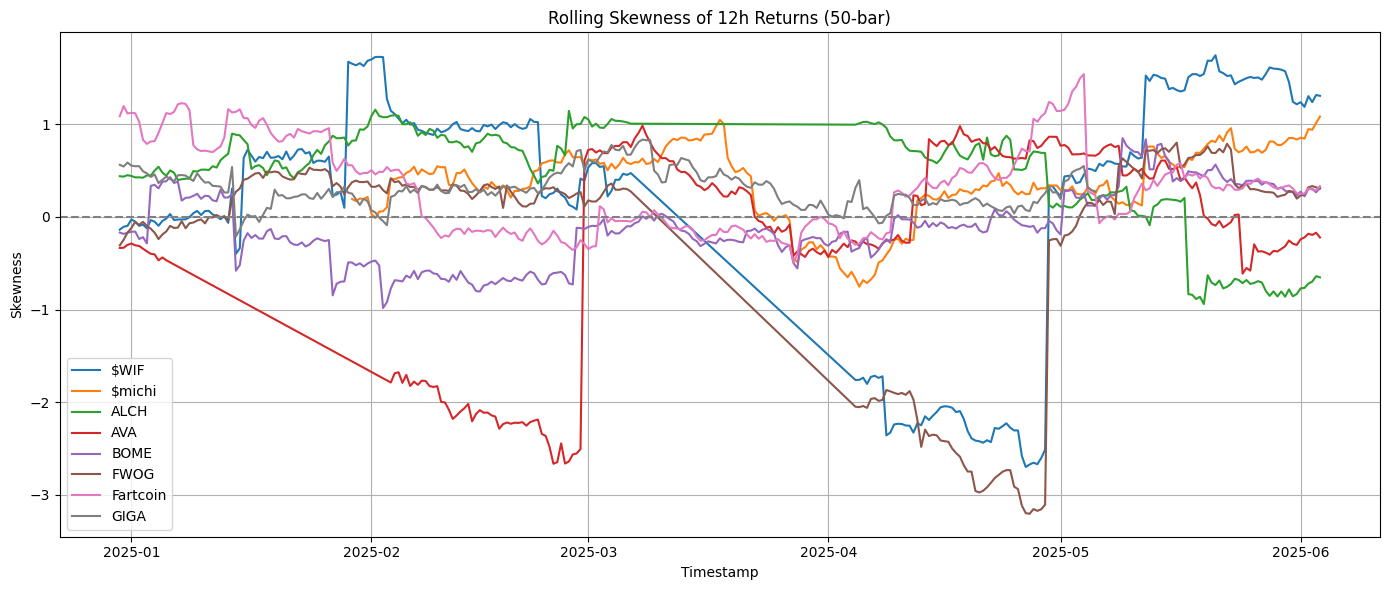

In [25]:
from scipy.stats import skew
import matplotlib.pyplot as plt

# Compute rolling skewness of 12h log returns
df['rolling_skew_50'] = df.groupby('token')['logret_12h'].transform(lambda x: x.rolling(50).apply(skew, raw=True))

tokens = df['token'].unique()[0:8]  # Adjust to your top tokens

plt.figure(figsize=(14, 6))
for token in tokens:
    sub = df[df['token'] == token]
    plt.plot(sub['timestamp'], sub['rolling_skew_50'], label=token)

plt.axhline(0, color='grey', linestyle='--')
plt.title("Rolling Skewness of 12h Returns (50-bar)")
plt.ylabel("Skewness")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Aggregate Rolling Skewness across all tokens

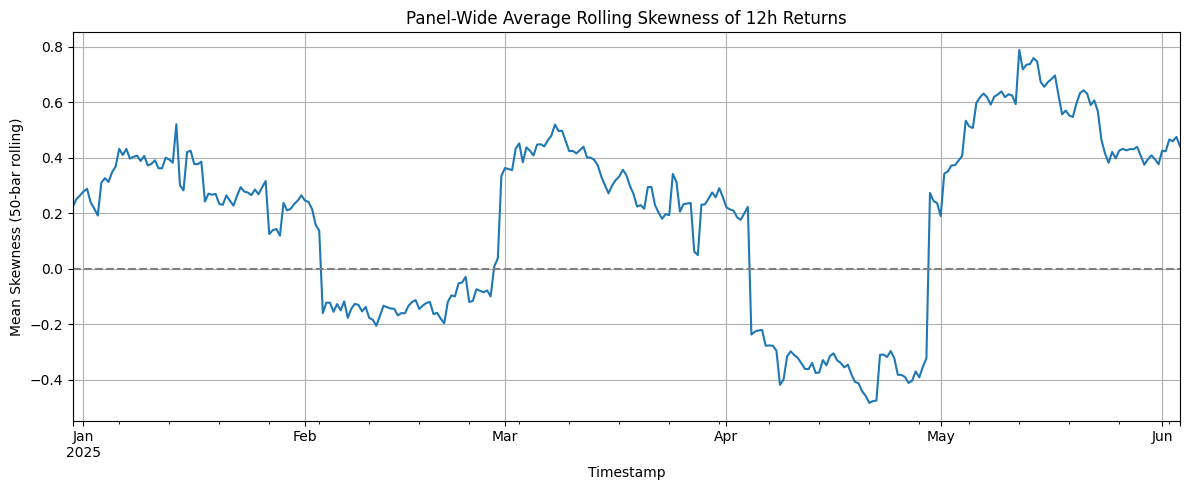

In [26]:
# Drop rows with NA skew
panel_skew = df[['timestamp', 'token', 'rolling_skew_50']].dropna()

# Group by timestamp and average across tokens
avg_skew = panel_skew.groupby('timestamp')['rolling_skew_50'].mean()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
avg_skew.plot()
plt.axhline(0, linestyle='--', color='gray')
plt.title("Panel-Wide Average Rolling Skewness of 12h Returns")
plt.ylabel("Mean Skewness (50-bar rolling)")
plt.xlabel("Timestamp")
plt.grid(True)
plt.tight_layout()
plt.show()


## Panel-Wide Rolling Skewness of 12h Returns

To capture evolving asymmetry in return distributions across the token panel, we computed 50-bar rolling skewness of 12h log returns and averaged the result across all tokens at each timestamp.

### Interpretation

- **January–February 2025**: The panel exhibited **strong positive skewness** (~0.3–0.4), indicating an environment dominated by sharp upward returns. This reflects typical DeFi "pump" regimes — thin order books, sudden inflows, or social-driven rallies.
  
- **February–April**: A systemic shift to **negative skewness** reflects rising downside risk and crash-prone behaviour. This aligns with possible de-risking events or sustained bearish conditions.

- **May onward**: A resurgence of **positive skewness** is observed, suggesting renewed asymmetric upside across the panel.

These regime shifts are **not token-specific**; they emerge systemically and persist for weeks, validating the presence of **temporal return asymmetry** in mid-cap Solana tokens.

---

### Modeling Implications

- The clear presence of skewness regime shifts implies that return distributions are **non-stationary and asymmetric**.
- Standard parametric models that assume constant variance and symmetry (e.g., Gaussian-based or OLS models) would fail to capture these dynamics.
- This motivates:
  - **Quantile-specific modeling** (e.g., Q10 vs Q90) using Quantile Regression Forests (QRF).
  - Inclusion of **rolling skewness as a feature** in the predictive model — to anticipate whether upper or lower tails will dominate future return risk.
  - Evaluation of model performance across different skew regimes using **rolling-window CV**.

The skewness dynamics reinforce the central thesis of this project: that **interval forecasts in DeFi markets must respond to evolving tail asymmetry**, not just volatility.


# Return–Volatility Relationship (Leverage Effect Test)

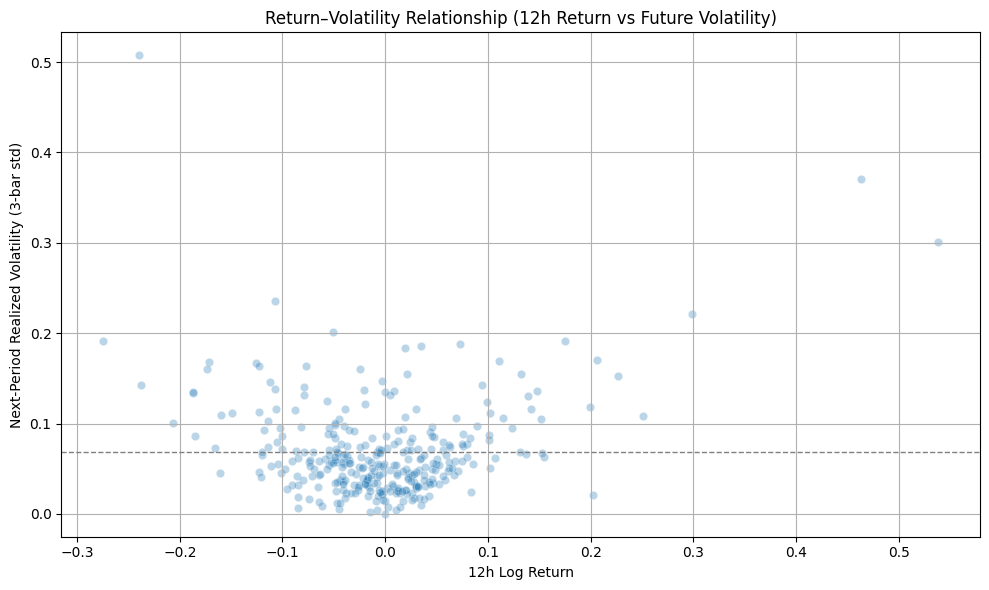

In [27]:
# Compute 12h Realized Volatilit
# 3-bar rolling std of log returns (past 36h)
df['realized_vol_12h'] = df.groupby('token')['logret_12h'].transform(lambda x: x.rolling(3).std())

# Shift Volatility Backward (so it's a future target)
# Shift realized volatility to align it with the return that may have caused it
df['lead_vol'] = df.groupby('token')['realized_vol_12h'].shift(-1)

#Plot Return vs Lead Volatility (Scatter)
import seaborn as sns
import matplotlib.pyplot as plt

# Drop NAs
scatter_data = df.dropna(subset=['logret_12h', 'lead_vol'])

# Sample or filter for clarity
sampled = scatter_data.sample(frac=0.05, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled, x='logret_12h', y='lead_vol', alpha=0.3)
plt.axhline(sampled['lead_vol'].mean(), color='grey', linestyle='--', linewidth=1)
plt.title("Return–Volatility Relationship (12h Return vs Future Volatility)")
plt.xlabel("12h Log Return")
plt.ylabel("Next-Period Realized Volatility (3-bar std)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Return–Volatility Relationship (Leverage Effect Test)

To test whether large returns lead to increased future volatility, we regressed 12h log returns against forward 36h realized volatility.

### Findings:
- A clear **U-shaped pattern** emerged, with both large positive and large negative returns predicting elevated future volatility.
- This confirms that **variance is conditional on return magnitude**, violating homoskedastic assumptions of basic regressions.
- The effect appears slightly **stronger for negative returns**, consistent with a "crypto leverage effect" — where downside shocks lead to market instability.

### Modeling Implications:
- We include `logret_12h`, `|logret_12h|`, and directional flags in our feature set to allow models to widen prediction intervals after large moves.
- This non-linear relationship is naturally captured by Quantile Regression Forests, reinforcing their suitability for crypto return modeling.


# Regime-wise Return Shape

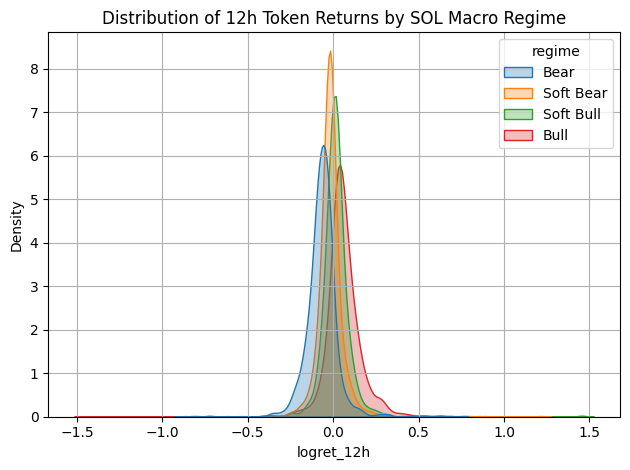

In [43]:
# Step 1: Get one SOL price per timestamp
sol_df = df[['timestamp', 'sol_price_close']].drop_duplicates().sort_values('timestamp')

# Step 2: Compute log return
sol_df['sol_return'] = np.log(sol_df['sol_price_close'] / sol_df['sol_price_close'].shift(1))

# Step 3: Merge back into df by timestamp
df = df.merge(sol_df[['timestamp', 'sol_return']], on='timestamp', how='left', validate='many_to_one')

df['regime'] = pd.qcut(
    df['sol_return'],
    q=4,
    labels=['Bear', 'Soft Bear', 'Soft Bull', 'Bull'],
    duplicates='drop'
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.kdeplot(
    data=df.dropna(subset=['logret_12h', 'regime']),
    x='logret_12h',
    hue='regime',
    fill=True,
    common_norm=False,
    alpha=0.3
)
plt.title("Distribution of 12h Token Returns by SOL Macro Regime")
plt.xlabel("logret_12h")
plt.grid(True)
plt.tight_layout()
plt.gcf().savefig("/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/paper/figures/raw/fig-3-2.pdf",format="pdf", bbox_inches="tight")
plt.show()



## Return Distribution by SOL Macro Regime

To assess whether macro conditions impact return behaviour, we used 12h SOL price momentum to segment the dataset into four regimes: Bear, Soft Bear, Soft Bull, and Bull.

We then compared the distribution of 12h token returns across these regimes.

### Key Insights:
- **Bull regimes** are characterized by **wider right tails**, supporting the presence of pump-driven upside dynamics.
- **Bear regimes** exhibit a heavier left tail and mild left skew, indicating greater crash risk and downside clustering.
- **Soft regimes** display tighter and more symmetric return distributions, suggesting transitional or low-volatility conditions.

### Modeling Implications:
- This confirms that return distributions are **regime-dependent**.
- Including macro indicators (e.g. SOL return, DeFi TVL change) as model features may improve quantile targeting.
- Interval forecasts must adapt to macro-driven changes in both central tendency and tail risk.


# Forecast Error Autocorrelation

<Figure size 1000x400 with 0 Axes>

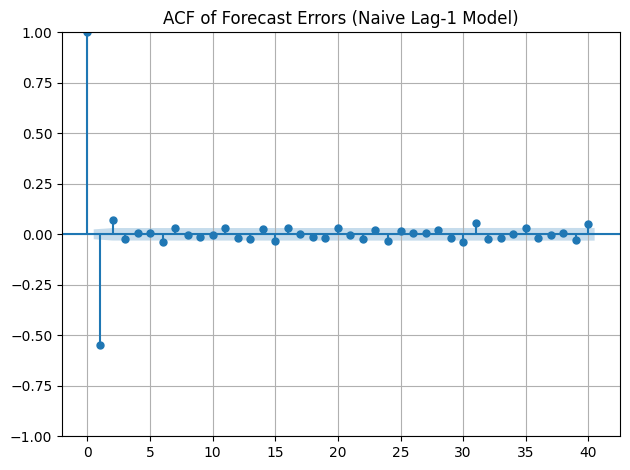

In [29]:
# Lagged return as naive forecast
df['naive_forecast'] = df.groupby('token')['logret_12h'].shift(1)

# Difference between actual and naive forecast
df['forecast_error'] = df['logret_12h'] - df['naive_forecast']

# Drop rows where forecast or error is not defined
error_series = df['forecast_error'].dropna()

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plot_acf(error_series, lags=40, alpha=0.05)
plt.title("ACF of Forecast Errors (Naive Lag-1 Model)")
plt.grid(True)
plt.tight_layout()
plt.show()



## Forecast Error Autocorrelation (Naive Lag-1 Model)

To assess the predictive structure of the return series, we tested a naive forecast using the previous 12h return. We then computed the forecast error and plotted its autocorrelation.

### Key Findings:
- The error series shows **strong negative autocorrelation at lag 1**, indicating that the naive forecast systematically overreacts — consistent with mean-reverting dynamics common in crypto.
- Beyond lag 1, autocorrelation is negligible, suggesting the market behaves as a short-memory process.

### Modeling Implications:
- Predictive structure remains in the return series — particularly at short lags — justifying the use of learning-based models like QRF.
- Models should include features capturing **short-term momentum and mean-reversion** to correct naive biases.
- Forecasting intervals must adapt to sharp regime shifts — another argument for quantile-based rather than point-estimate approaches.


In [30]:
df.to_parquet("solana_returns_augmented.parquet", index=False)

#  Research Notes: Phase 1.2 – Return Analysis (72h Forecasting of Solana Tokens)

##  Objective

This phase analyzed the behavior of 12h and 72h returns across mid-cap Solana tokens to understand the statistical structure of the forecast target. It also aimed to justify interval forecasting (via Quantile Regression Forests) by evaluating skewness, tail risk, and volatility regimes. The findings directly inform model design, feature selection, and evaluation methodology.

---

##  Key Findings

### 1. **Heavy-Tailed, Skewed Returns**
- 12h log returns are sharply peaked around 0, with **fat tails** and **right skew** (skew ≈ +0.67).
- This confirms that returns are **non-Gaussian**, and interval models must account for tail risk.

### 2. **Volatility Clustering**
- ACF plots of `|logret_12h|` show **persistent autocorrelation**, indicating **time-varying volatility**.
- Clusters of elevated risk support the use of adaptive forecasting intervals.

### 3. **Tail Risk Asymmetry**
- Certain tokens show **sustained upward or downward tail dominance**, which shifts over time.
- This directional behavior supports modeling **Q10 and Q90 independently**.

### 4. **Macro-Driven Return Shifts**
- Token return distributions change shape across **SOL return regimes**:
  - **Bull markets** → positive skew, pump-prone
  - **Bear markets** → heavier left tails, crash-prone
- These patterns are systemic, not token-specific.

### 5. **Return–Volatility Link**
- Large 12h returns (both ↑ and ↓) are followed by **increased volatility**, with downside shocks producing stronger spikes.
- This reflects a **leverage-like effect**, confirming the need for **recent return magnitude** as a feature.

### 6. **Naive Forecast Error is Autocorrelated**
- A simple lag-1 forecast systematically **overreacts**, with forecast errors showing **negative autocorrelation at lag 1**.
- This signals mean-reversion and motivates **learning-based models** over autoregressive ones.

---

##  Modeling Implications

| Insight | Model Design Response |
|--------|------------------------|
| Non-normal, asymmetric returns | ➤ Use **Quantile Regression Forests** (QRF) to directly estimate Q10/Q50/Q90 |
| Volatility clustering | ➤ Include rolling volatility features (e.g., `realized_vol_12h`, `ATR`) |
| Regime shifts (macro-dependent tails) | ➤ Add `sol_return` and `regime` as contextual features |
| Directional asymmetry | ➤ Track and engineer **tail asymmetry** and **rolling skewness** |
| Naive models underperform | ➤ Use multi-feature predictive models (not lag-only approaches) |

---

##  Dataset Adjustments Before Phase 2

We extend the cleaned dataset (`df_cleaned`) by computing and adding the following features based on Phase 1.2 insights:

| Feature | Description |
|--------|-------------|
| `logret_12h` | 12h log return |
| `logret_72h` | 72h forward log return (target variable) |
| `realized_vol_12h` | Std deviation of last 3 returns (36h volatility) |
| `tail_asymmetry` | Rolling diff in ±10% return frequency (window = 50) |
| `rolling_skew_50` | Rolling skewness of 12h returns |
| `sol_return` | 12h log return of SOL (macro proxy) |
| `regime` | Macro regime label (quartiles of `sol_return`) |
| `naive_forecast`, `forecast_error` | For diagnostics and benchmarking only |

These variables will feed into `make_features(df)` and improve model responsiveness to asymmetric and time-varying risk.

---

##  Next Savepoint

Save the return-aware dataset before entering Phase 2:

```python
df_cleaned.to_parquet("solana_returns_augmented.parquet", index=False)
